In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
from IPython.display import display, HTML
import numpy as np
import seaborn as sns
import scipy as sp
from scipy.stats import gamma
import tqdm


import matplotlib as matp

matp.rcParams['mathtext.fontset'] = 'stix'
matp.rcParams['font.family'] = 'STIXGeneral'

## Problem:  Traveling Salesman Problem

Given a graph $G=(V,E)$ with $N=|V|$ nodes (cities), what is the cheapest hamiltonian cycle, considering the edge $e_{i,j}$ as the cost from going from city $i$ to city $j$?

The Quadratic Unconstrained Binary Optimization model can be formulated in the following way

\begin{align}
	H = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}  + M \bigg[ \sum_{i=1}^{N}  \left( 1- \sum_{t=1}^{N} x_{t, i} \right)^2 + \sum_{t=1}^{N}  \left( 1- \sum_{i=1}^{N} x_{t, i} \right)^2  \bigg]\, ,
\end{align}

and the decision variable $\{x_{t, i}\}_{i,t=1,\dots,N} \in \{0,1\}^{N^2}$ is defined as

\begin{align}
	x_{t, i} = 
    \begin{cases}
	1 & \text{if city } i \text{ is visited at time step } t \\
	0 & \text{else}
    \end{cases} \, .
\end{align}

The constraint enforces the decision matrix $[x]_{t, i}$ to be a permutation matrix, ordering the temporal visit of each city.

- $N$: Number of cities/nodes.
- ${\rm{bits}} = N^2$: Number of bits needed to represent problem QUBO.
- $M$: Penalty factor.

#### Test scenario:
For each case with $N=[8, 16, 24, 32, 40, 48, 56, 64]$, 17 problem instances have been generated (all equal? where does the $\rm{seed}$ come into play?). The graph structure is circular in the present experiment set: nodes are placed equally spaced on the circumference of a circle of radius $r=1000000$. The edges values are the euclidian distances between pair of nodes.
For each case and each problem instance, 128 runs have been exectued. The number of DA iterations has been chosen $\rm{bits^2}$. Automatic temperature tuning has been selected. The penalty factor $M$ varies from $10^4$ to $10^8$ in scaling steps of $10^{i /8}$ in the general picture, with a focus along the transition phase (around $10^6$) with $10^{i /32}$ scaling steps.




## Read data for analysis

Data is stored in `{n_bits}bits.json` files.

Objective function values of valid solutions will be stored (in the next cells) in `valids`. For every number of bits, for every $M$ penalty factor and for every seed (i.e. instance), `valids[bits_idx][M_idx]` contains a list of length at most $128$ with the energies reached by valid solutions during the $128$ runs.

In [2]:
#colors = sns.color_palette("Paired", 12)

colors = sns.color_palette("Paired", 12)

N_cities =  np.arange(4, 65, 2)
BITS = N_cities**2
Ms = ['25000', '50000', '75000', '100000', '125000', '150000', '175000', '200000', '225000', '250000', '275000', '300000', '325000', '350000', '375000', '400000', '405000', '410000', '415000', '420000', '425000', '430000', '435000', '440000', '445000', '450000', '455000', '460000', '465000', '470000', '475000', '480000', '485000', '490000', '495000', '500000', '505000', '510000', '515000', '520000', '525000', '530000', '535000', '540000', '545000', '550000', '555000', '560000', '565000', '570000', '575000', '580000', '585000', '590000', '595000', '600000', '625000', '650000', '675000', '700000', '725000', '750000', '775000', '800000', '825000', '850000', '875000', '900000', '925000', '950000', '975000', '1000000', '1025000', '1050000', '1075000', '1100000', '1125000', '1150000', '1175000', '1200000', '1225000', '1250000', '1275000', '1300000', '1325000', '1350000', '1375000', '1400000', '1425000', '1450000', '1475000', '1500000', '1525000', '1550000', '1575000', '1600000', '1625000', '1650000', '1675000', '1700000', '1725000', '1750000', '1775000', '1800000', '1825000', '1850000', '1875000', '1900000', '1925000', '1950000', '1975000', '2000000']
Ms = np.array([int(M) for M in Ms])
runs = 128
n_dseeds = 4
n_vseeds = 1

print(len(N_cities), N_cities)

31 [ 4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50
 52 54 56 58 60 62 64]


In [3]:
### open files and fill data structures with data

directory = "../data/scan_TSP/"

data = np.ndarray(shape = (len(BITS), len(Ms), n_vseeds, n_dseeds, runs, 2))
data_temp = np.ndarray(shape = (len(BITS), len(Ms), n_vseeds, n_dseeds, 2)) # the final index is 0 for starting temperature, 1 for final temperature

for N_idx, N in enumerate(N_cities):
    bits = BITS[N_idx]
    filename = directory + f'results-N={N}-short.json'
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue        

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        summary = {int(M):{seed:summary[M][seed] for seed in summary[M]} for M in sorted(list(summary.keys()))}
        
        seed_ids = []
        for M in sorted(list(summary.keys())):
            for seed_id in summary[M]:
                if seed_id not in seed_ids:
                    seed_ids.append(seed_id)
        seed_ids = sorted(list(set(seed_ids)))
        vseeds = sorted(list(set([seed_id.split('-')[0] for seed_id in seed_ids])))
        daseeds = sorted(list(set([seed_id.split('-')[1][:2] for seed_id in seed_ids])))
        
        assert len(vseeds) == n_vseeds and len(daseeds) == n_dseeds

        for M_idx, M in enumerate(sorted( list(summary.keys()) )):
            for vseed_idx, vseed in enumerate(vseeds):
                for daseed_idx, daseed in enumerate(daseeds):
                    ener_key = str(vseed) + "-" + str(daseed)
                    t_key = ener_key + "_data"
                    data[N_idx, M_idx, vseed_idx, daseed_idx] = summary[M][ener_key]
                    data_temp[N_idx, M_idx, vseed_idx, daseed_idx, 0] = summary[M][t_key]["temperature_start"]
                    data_temp[N_idx, M_idx, vseed_idx, daseed_idx, 1] = summary[M][t_key]["temperature_end"]

        print(f'Read data --> {N:,d} cities, {bits:,d} bits --> Done')

Read data --> 4 cities, 16 bits --> Done
Read data --> 6 cities, 36 bits --> Done
Read data --> 8 cities, 64 bits --> Done
Read data --> 10 cities, 100 bits --> Done
Read data --> 12 cities, 144 bits --> Done
Read data --> 14 cities, 196 bits --> Done
Read data --> 16 cities, 256 bits --> Done
Read data --> 18 cities, 324 bits --> Done
Read data --> 20 cities, 400 bits --> Done
Read data --> 22 cities, 484 bits --> Done
Read data --> 24 cities, 576 bits --> Done
Read data --> 26 cities, 676 bits --> Done
Read data --> 28 cities, 784 bits --> Done
Read data --> 30 cities, 900 bits --> Done
Read data --> 32 cities, 1,024 bits --> Done
Read data --> 34 cities, 1,156 bits --> Done
Read data --> 36 cities, 1,296 bits --> Done
Read data --> 38 cities, 1,444 bits --> Done
Read data --> 40 cities, 1,600 bits --> Done
Read data --> 42 cities, 1,764 bits --> Done
Read data --> 44 cities, 1,936 bits --> Done
Read data --> 46 cities, 2,116 bits --> Done
Read data --> 48 cities, 2,304 bits --> Done

In [4]:
### SANITY CHECK: check integrity of the data, parameters are all as expected, with asserts: 
#           #_iter = n**2       temp_mode = 0 (exponential)        temp_interval = N)

for N_idx, N in enumerate(N_cities):
    bits = N**2    
    filename = f'results-N={N}-short.json'
    if not os.path.isfile(filename):
        print(f"{filename} doesn't exist")
        continue        

    with open(filename, 'r') as fp:
        summary = json.load(fp)
        summary = {int(M):{seed:summary[M][seed] for seed in summary[M]} for M in sorted(list(summary.keys()))}
        
        seed_ids = []
        for M in sorted(list(summary.keys())):
            for seed_id in summary[M]:
                if seed_id not in seed_ids:
                    seed_ids.append(seed_id)
        seed_ids = sorted(list(set(seed_ids)))
        vseeds = sorted(list(set([seed_id.split('-')[0] for seed_id in seed_ids])))
        daseeds = sorted(list(set([seed_id.split('-')[1][:2] for seed_id in seed_ids])))

        assert len(vseeds) == n_vseeds and len(daseeds) == n_dseeds

        for M in list(summary.keys()):
            for vseed in vseeds:
                for daseed in daseeds:
                    key = str(vseed) + "-" + str(daseed) + "_data"
                    assert summary[M][key]["number_runs"] == 128
                    assert summary[M][key]["number_iterations"] == bits**2
                    assert summary[M][key]["temperature_mode"] == 0
                    assert summary[M][key]["temperature_interval"] == N                  

results-N=4-short.json doesn't exist
results-N=6-short.json doesn't exist
results-N=8-short.json doesn't exist
results-N=10-short.json doesn't exist
results-N=12-short.json doesn't exist
results-N=14-short.json doesn't exist
results-N=16-short.json doesn't exist
results-N=18-short.json doesn't exist
results-N=20-short.json doesn't exist
results-N=22-short.json doesn't exist
results-N=24-short.json doesn't exist
results-N=26-short.json doesn't exist
results-N=28-short.json doesn't exist
results-N=30-short.json doesn't exist
results-N=32-short.json doesn't exist
results-N=34-short.json doesn't exist
results-N=36-short.json doesn't exist
results-N=38-short.json doesn't exist
results-N=40-short.json doesn't exist
results-N=42-short.json doesn't exist
results-N=44-short.json doesn't exist
results-N=46-short.json doesn't exist
results-N=48-short.json doesn't exist
results-N=50-short.json doesn't exist
results-N=52-short.json doesn't exist
results-N=54-short.json doesn't exist
results-N=56-sh

In [5]:
### useful functions

def L1_norm(Q, const):
    return const + np.sum(np.abs(Q))

def L1_norm_hot(Q, const, n_bits, temperature, max_prob_inf):
    return L1_norm(Q, const) + temperature*(n_bits*np.log(2) - np.log(max_prob_inf))

def nearest_to(ref_array, element):
    """
    Given a requested element (e.g. energy), returns the nearest value in a reference array, together with its position in the array
    """
    diff = np.abs(ref_array - element)
    idx = np.where(diff == np.min(diff))[0][0]
    return idx, ref_array[idx]

### QUBo generation functions

def get_QUBO_TSP(Nc, M, seed, circle_flag = False, objective = True, penalization=True):
    # build a TSP QUBO with Nc cities, M penalty factor, for problem identified with seed
    Q, const = np.zeros((Nc**2, Nc**2)), 0
    if objective:
        distances = build_adjacency(Nc, seed, circle_flag)
        Ho, const_o = build_obj_TSP(distances, Nc)
        Q += Ho
        const += const_o
    if penalization:
        Hp, const_p = build_pen_TSP(Nc)
        Q += M*Hp
        const += M*const_p
    return Q, const

def build_adjacency(Nc, seed, circle_flag):
    if circle_flag:
        # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
        coordinates = [(1_000_000 * np.cos((index / Nc) * 2 * np.pi), 1_000_000 * np.sin((index / Nc) * 2 * np.pi)) for index in range(Nc)]
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    else:
        # random construction of the adjacency matrix, based on euclidian distance. (cities are uniformly randomly placed inside a square)
        np.random.seed(seed)
        coordinates = 1e6 * np.array( [np.random.uniform(low = -1, high = 1, size = 2) for i in range(Nc)] )
        distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(Nc)] for c_1 in range(Nc)]
    return np.array(distance_table)

def build_obj_TSP(distances, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = distances[i, i_prime]
    H = symmetrize(H)
    const = 0
    return H, const

def build_pen_TSP(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    H = symmetrize(H)
    return H, const

def idx_onehot(i, p, P):
    return i*P + p

def symmetrize(Q):
    return (Q + Q.T)/2



### not reimplemented for TSP data, may not work
def print_table(N, data):
    """
    Prints a table recapping, for ever M, the number of feasible solutions, the rate, the min energy and the mean energy
    """
    table = []
    N_idx = np.where(Ns == N)[0][0]
    for M_idx, M in enumerate(Ms):
        feasible = (data[N_idx, M_idx, ..., 1] == 0)
        sum = data[N_idx, M_idx, ..., 1] + data[N_idx, M_idx, ..., 0]
        counter = 128*8*8
        values = [sum.flatten()[j] for j in range(counter) if feasible.flatten()[j]] 

        l = len(values)
        min_e = min(values) if l > 0 else None
        mean_e = np.mean(values) if l > 0 else None
        rate = 100*len(values)/counter
        row = [M, min_e, mean_e, l, rate]
        table.append(row)
    header = ['M', f'min', f'mean', f'quantity', 'rate']
    display(HTML(tabulate(table, header, tablefmt='html')))
    return


def compute_valnrate_forM(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    sum = data_NM[..., 1] + data_NM[..., 0]
    counter = n_vseeds*n_dseeds*runs
    values = np.array([sum.flatten()[j] for j in range(counter) if feasible.flatten()[j]])
    rate = 100*len(values)/counter
    return values, rate, counter

def compute_rate_forM(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    rate = 100*np.sum(feasible)/(n_vseeds*n_dseeds*runs)
    return rate


def compute_rate_forM_forinst(data_NM):
    """
    For a given N and M, returns the obj value of feasible points, together with the feasibility rate
    """
    feasible = (data_NM[..., 1] == 0)
    rate = 100*np.sum(feasible)/(n_dseeds*runs)
    return rate


def bootstrap(values, total, bs_size = 5):
    """
    Bootstraps the feasible value obtained (values) with a certain size. Returns success rate of bootstrapping and mean of the bests.
    """
    values = np.concatenate((values, -100*np.ones(total - len(values))))
    np.random.shuffle(values)

    n_straps = total // bs_size
    bests = []
    success = 0
    for i in range(n_straps):
        v = values[i*bs_size : (i+1)*bs_size]
        if np.any(v >= 0):
            success += 1
            bests.append(min(v[v>=0]))

    succ_rate = 100*success/n_straps
    return succ_rate, np.mean(bests)


def optimum_circle(bits):
    N_cities = int(np.sqrt(bits))
    coordinates = [(1_000_000 * np.cos((i/N_cities) * 2 * np.pi), 1_000_000 * np.sin((i/N_cities) * 2 * np.pi)) for i in range(N_cities)]
    optimum = N_cities*int(np.sqrt((coordinates[1][0] - coordinates[0][0]) ** 2 + (coordinates[1][1] - coordinates[0][1]) ** 2))
    return optimum

def flatten_2d(l):
    return np.array( [x for a in l for x in a] )

## DA temperature

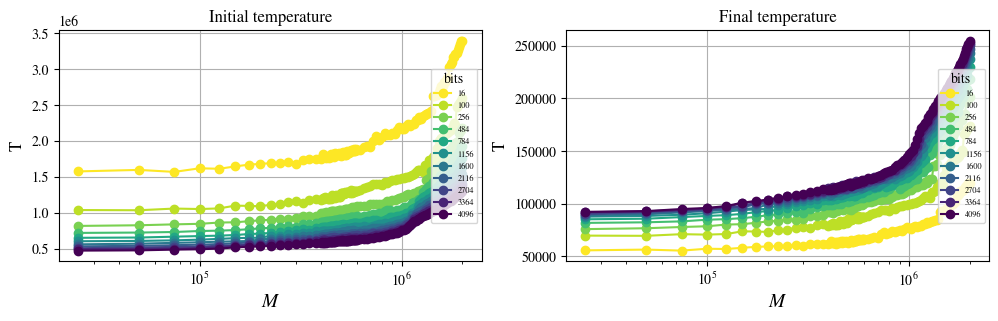

In [6]:
def plot_temperature(data_temp, Nc_toplot):
    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(Nc_toplot)))) 
    # plot
    fig = plt.figure(figsize=(12, 3))
    for k in range(2): # k = 0/1 for initial/final temperature
        ax = fig.add_subplot(1, 2, k+1)
        for N_idx, N in enumerate(Nc_toplot):
            ax.plot(Ms, np.mean(data_temp[N_idx, :, ..., k], axis = (1,2)),"-o", color = discr_colors.colors[N_idx], label = f'{N**2}')
        ax.set_ylabel("T", fontsize=12)
        ax.set_xlabel(r"$M$",fontsize=14)
        ax.legend(fontsize = 6, loc='right', title = "bits")
        plt.xscale('log')
        if k == 0:
            ax.set_title("Initial temperature")
        elif k == 1:
            ax.set_title("Final temperature")
        plt.grid()
    plt.show()
    return

Nc_toplot = N_cities[::3]
plot_temperature(data_temp, Nc_toplot)

## Rates, energies and bootstrap

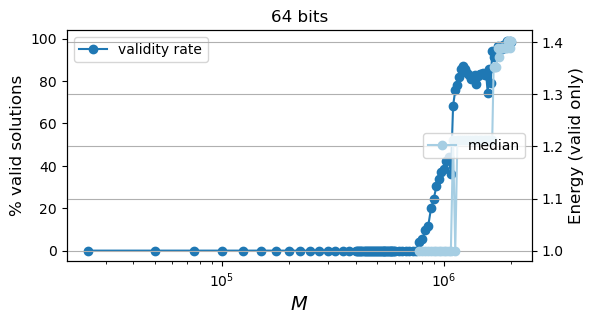

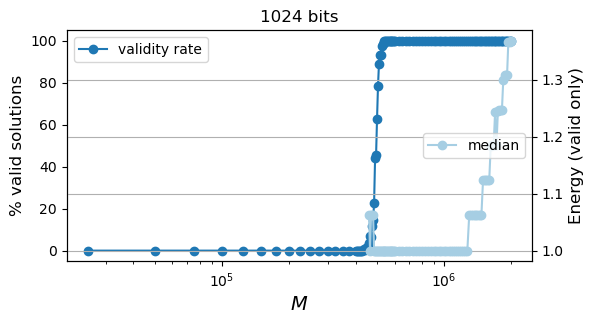

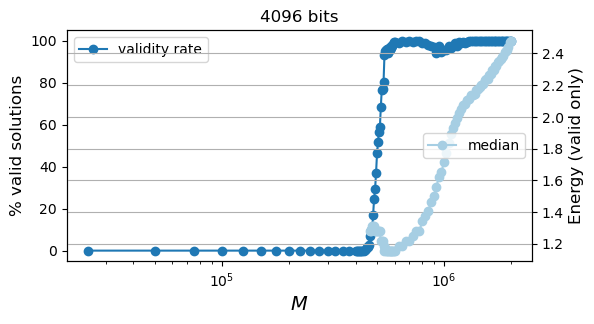

In [7]:
def plot_ener_rates(data_N, N, plot_rate_thr = 10, bs_size = None, optimum = None):
    """
    Computes and plots, as a function of M, median and mean energy, feasibility rate.
    Also, if bs_size is an integer, applies bootstrap and plots success rate and bootstrap mean energy
    """
    fig, ax = plt.subplots(1, 1, figsize=(6,3))
    ax2 = ax.twinx()

    # get data to plot
    means, medians, rates, counts = np.ndarray(len(Ms)), np.ndarray(len(Ms)), np.ndarray(len(Ms)), np.ndarray(len(Ms))
    if bs_size != None:
        bs_succ_rate, bs_best = np.ndarray(len(Ms)), np.ndarray(len(Ms))
    for M_idx, M in enumerate(Ms):
        values, rates[M_idx], total = compute_valnrate_forM(data_N[M_idx])
        counts[M_idx] = len(values)
        
        if counts[M_idx] > 0:
            means[M_idx], medians[M_idx] = np.mean(values), np.median(values)
            if bs_size != None:
                bs_succ_rate[M_idx], bs_best[M_idx] = bootstrap(values, total, bs_size = bs_size)

    # plot
    ax.plot(Ms, rates,"-o", color = colors[1], label = 'validity rate')
    mask = [r and c for r,c in zip(rates > plot_rate_thr, counts > 0)]
    #ax2.plot( Ms[mask], means[mask],"-o", c=colors[1], label = 'mean')
    ax2.plot( Ms[mask], medians[mask]/optimum,"-o", c=colors[0], label = 'median')
    if bs_size != None:
        ax2.plot( Ms[mask], bs_best[mask]/optimum,"-o", c=colors[2], label = 'bootstrap mean')
        ax.plot( Ms[mask], bs_succ_rate[mask],"-o", c=colors[3], label = 'bootstrap succ rate') 

    # refines plot
    ax2.set_ylabel("Energy (valid only)", fontsize=12)
    ax.set_ylabel("% valid solutions", fontsize=12)
    ax.set_xlabel(r"$M$",fontsize=14)
    ax2.legend(fontsize = 10, loc='center right')
    ax.legend(fontsize = 10, loc='upper left')
    bits_idx = np.where(BITS == bits)[0][0]
    plt.title(f"{BITS[bits_idx]} bits")
    plt.xscale('log')
    #plt.yscale('log')
    plt.grid()
    plt.show()
    return
        




for bits in [64, 1024, 4096]:
    bits_idx = np.where(BITS == bits)[0][0]
    optimum = optimum_circle(bits)  
    display(HTML(f"<h3>{N_cities[bits_idx]:,d} cities, {bits:,d} bits, {bits*bits:,d} iterations</h3>"))

    #print_table(data[bits_idx])
    
    plot_rate_thr = 3
    bootstrap_size = None#10
    plot_ener_rates(data[bits_idx], bits, plot_rate_thr, bs_size = bootstrap_size, optimum = optimum)


## Rates and phase transition

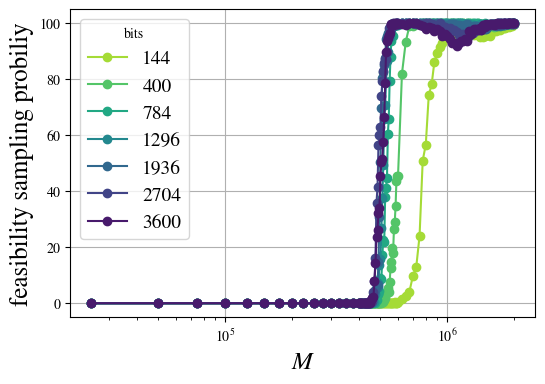

In [6]:
def plot_rates(data):
    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(BITS)))) 

    # get data to plot
    rates = np.ndarray((len(BITS),len(Ms)))
    for bits_idx in range(len(BITS)):
        for M_idx, M in enumerate(Ms):
            rates[bits_idx, M_idx] = compute_rate_forM(data[bits_idx, M_idx])

    # plot
    for bits_idx, bits in enumerate(BITS):
        if bits_idx % 4 == 0 and bits_idx > 1:
            ax.plot(Ms, rates[bits_idx],"-o", color = discr_colors.colors[bits_idx], label = f'{bits}')
    ax.set_ylabel("feasibility sampling probiliy", fontsize=18)
    ax.set_xlabel(r"$M$",fontsize=18)
    ax.legend(fontsize = 14, loc='best', title = "bits")
    plt.xscale('log')
    #ax.set_xticks(10**5*np.array([1, 1.5, 2, 2.5, 3]))
    plt.grid()
    plt.show()
    return

plot_rates(data)

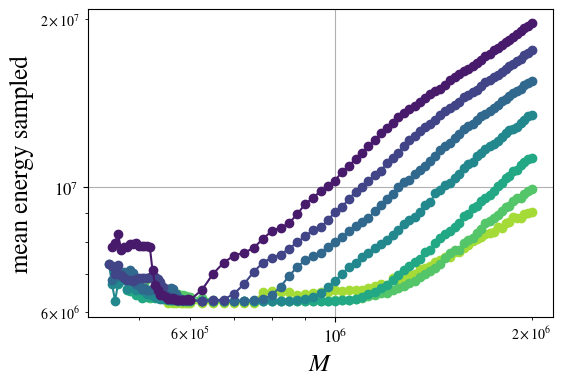

In [9]:
def plot_rates_and_energies(data):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    colormap = plt.cm.viridis.reversed()
    discr_colors = ListedColormap(colormap(np.linspace(0, 1, len(BITS)))) 

    # get data to plot
    rates, means = np.ndarray((len(BITS),len(Ms))), np.ndarray((len(BITS),len(Ms)))
    for N_idx in range(len(BITS)):
        for M_idx, M in enumerate(Ms):
            values, rates[N_idx, M_idx], _ = compute_valnrate_forM(data[N_idx, M_idx])
            means[N_idx, M_idx] = np.mean(values)
    

    # plot
    for bits_idx, bits in enumerate(BITS):
        if bits_idx % 4 == 0 and bits_idx > 1:
            mask_valid = (rates[N_idx] > 0) 
            ax.plot(Ms[mask_valid], means[bits_idx][mask_valid],"o-", color = discr_colors.colors[bits_idx], label = f'{bits}')
    ax.set_ylabel("mean energy sampled", fontsize=18)
    ax.set_xlabel(r"$M$",fontsize=18)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xticks(10**5*np.array([0.6, 1, 2, 3]))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #ax.legend(fontsize = 12, loc='best', title = "bits")
    ax.grid()
    #ax.set_xlim(3e4, 2e6)
    plt.show()
    return


plot_rates_and_energies(data)

## 3d (M - energy) heatmap

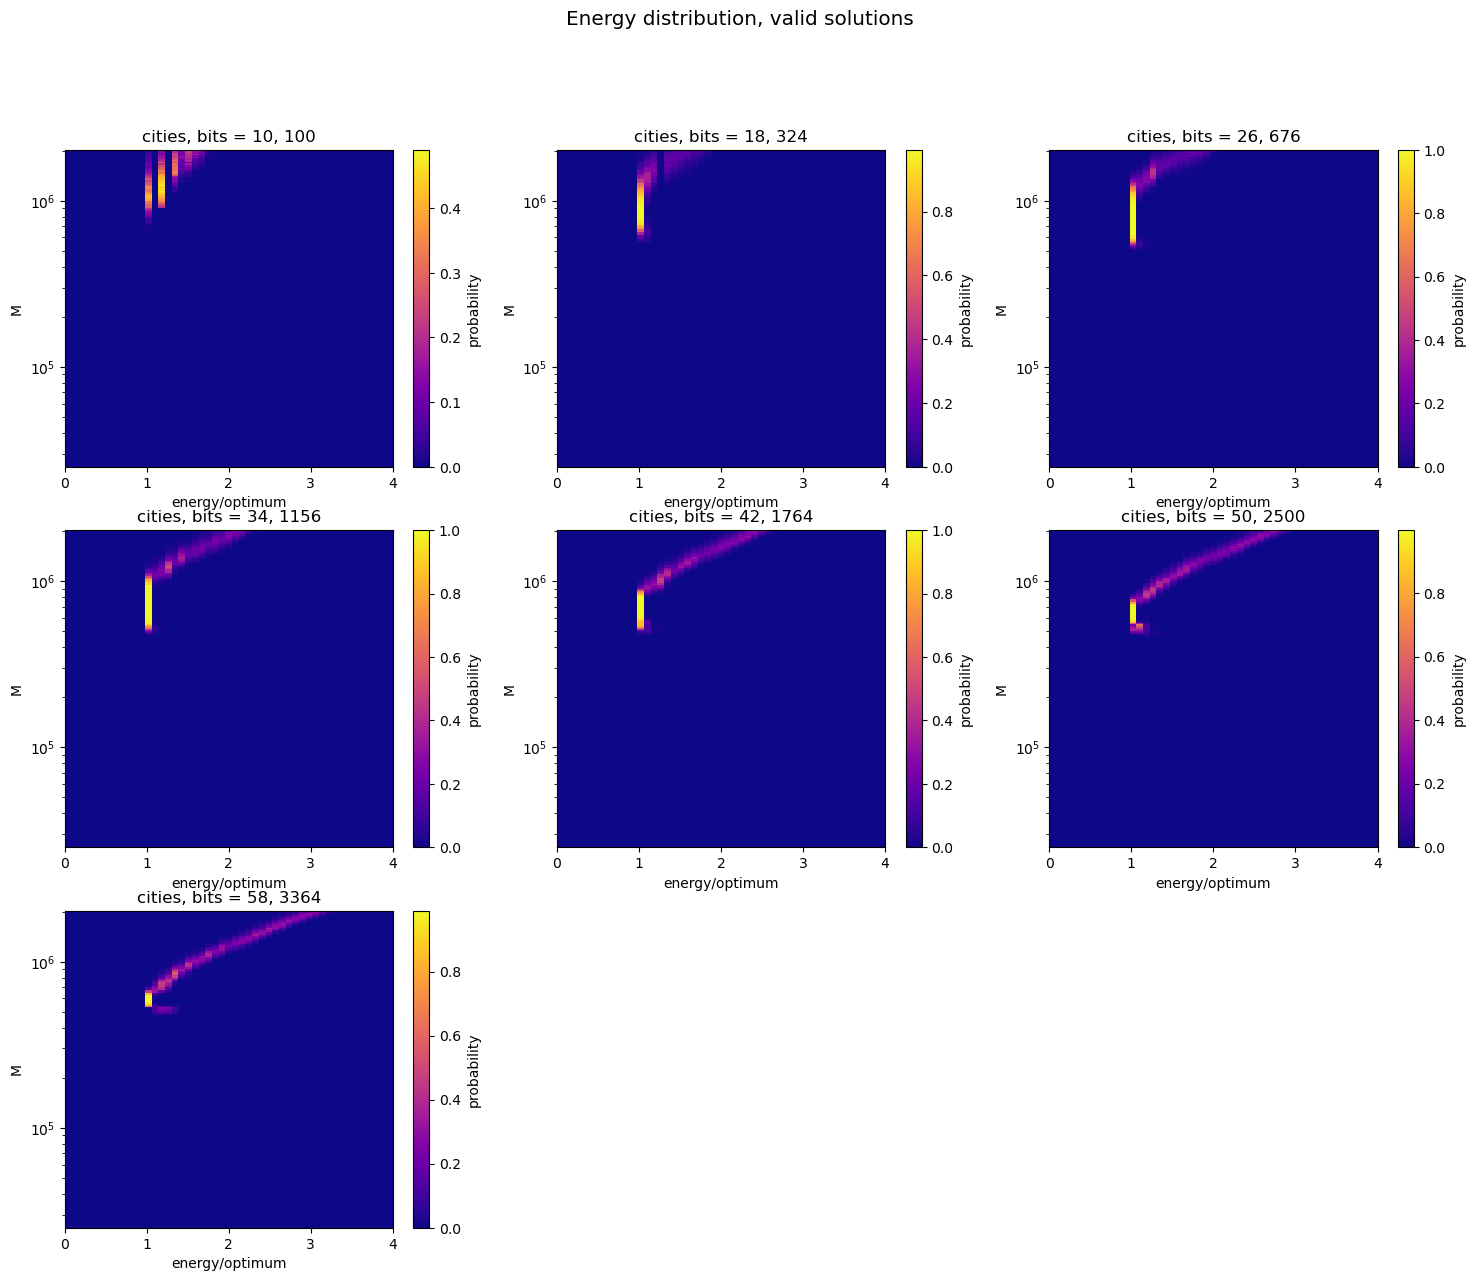

In [14]:
def plot_heatmap_ener(data, N_idx, which, ener_max, bins_ener, fig, plot_code):

    # get data to plot
    data_N = data[N_idx]
    ener = np.reshape(data_N, newshape = (len(Ms), n_vseeds*n_dseeds*runs, 2))
    M_list = np.array([])
    ener_list = np.array([])

    if which == 'valid':
        for M_idx, M in enumerate(Ms):
            valids = ener[M_idx, :, 1] == 0
            M_list = np.append(M_list, M*np.ones((sum(valids))))
            ener_list = np.append(ener_list, ener[M_idx, valids, 0])
    elif which == 'all':
        for M_idx, M in enumerate(Ms):
            M_list = np.append(M_list, M*np.ones(( len(ener[M_idx, :, 0]) )))
            ener_list = np.append(ener_list, ener[M_idx, :, 0] + ener[M_idx, :, 1])
    else:
        raise ValueError("energy histogram to plot not understood")
    
    optimum = optimum_circle(BITS[N_idx])
    ener_list /= optimum

        # get data in histogram-friendly format
    # set bins limits
    bins_ener = bins_ener
    ener_edges = np.linspace(0, ener_max, num=bins_ener)
    M_edges = np.concatenate((Ms, [Ms[-1]* Ms[-1]/Ms[-2]] )) # artificially add last M point with same log-distance
    # compute histogram 
    hist, xedges, yedges = np.histogram2d(ener_list, M_list, bins=[ener_edges, M_edges])
    dz = hist.T.flatten()
    max_height, min_height = np.max(dz),np.min(dz)

    # heatmap
    total = runs*n_vseeds*n_dseeds
    ax = fig.add_subplot(*plot_code)
    cmap = matplotlib.colormaps['plasma']
    pcm = ax.pcolormesh(xedges, yedges, hist.T/total, cmap=cmap, vmin=min_height/total, vmax=max_height/total)
    cbar = fig.colorbar(pcm, ax=ax)
    ax.set_yscale("log")
    ax.set_ylabel("M")
    ax.set_xlabel("energy/optimum")
    ax.set_title(f"cities, bits = {N_cities[N_idx]}, {BITS[N_idx]}")
    cbar.set_label('probability')

    # ####### plot M_exact bounds
    # M_exact = 6.28*10**6   # basically tight M from old paper (M = f(feas) - f_SDP. Now, M_exact = f(opt) - f_min = f(opt) = 2*pi*10**6)
    # ax.axhline(M_exact, color = "k") # Upper bound
    # ax.axhline(M_exact / (2*N_cities[N_idx]), color = "k") # Lower bound (i.e. M_exact / violation number of all-zeros solution)

    return
    

def plot_table_heatmaps(data, which, bits_toplot, ener_max, bins_ener = 50):
    fig = plt.figure(figsize=(18, 14))
    fig.suptitle(f"Energy distribution, {which} solutions", fontsize="x-large")
    for idx in range(len(bits_toplot)):
        plot_code = (3, 3, idx+1)
        N_idx = np.where(BITS == bits_toplot[idx])[0][0]
        plot_heatmap_ener(data, N_idx, which, ener_max, bins_ener, fig, plot_code)

    plt.show()
    return



bits_toplot = BITS[3::4]
ener_max = 4
plot_table_heatmaps(data, 'valid', bits_toplot, ener_max) # second argument: switch beetween "all" and "valids" to add/remove invalid solutions

## 2d histogram and temperatures

Fit:	dim: 37.86	Temp.:	229798.926
D.A. final Temp.:	221544 +/- 410.0 (avg over all instances and DA seeds)


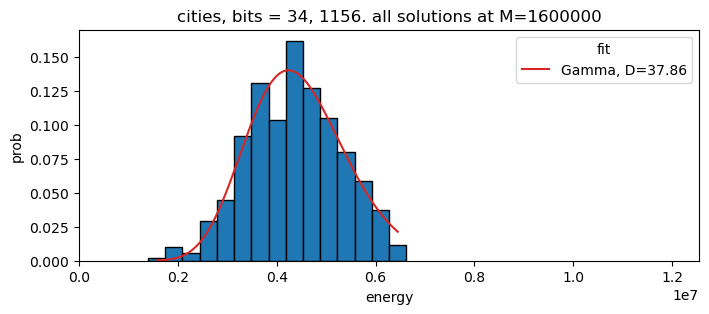

Fit:	dim: 67.1	Temp.:	169838.113
D.A. final Temp.:	240002 +/- 179.0 (avg over all instances and DA seeds)


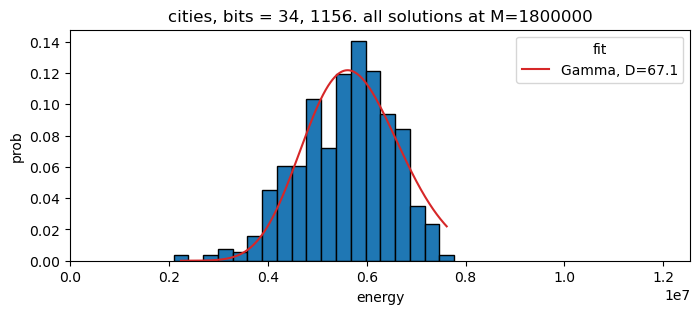

Fit:	dim: 151.09	Temp.:	90970.008
D.A. final Temp.:	260538 +/- 60.0 (avg over all instances and DA seeds)


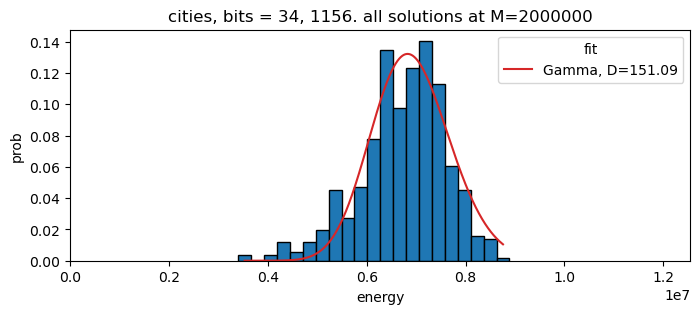

In [56]:
def plot_histo2d_ener_fit(data_N,  N_idx, M, which, bins, fit_lim = None, instance = 'all'):

    M_idx, M = nearest_to(Ms, M)
    # get data to plot
    if instance == 'all':
        ener = np.reshape(data_N[M_idx], newshape = (n_vseeds*n_dseeds*runs, 2))
    else:
        ener = np.reshape(data_N[M_idx, instance], newshape = (n_dseeds*runs, 2))

    if which == 'valid':
        valids = ener[:, 1] == 0
        y_ener = ener[valids, 0]
    elif which == 'all':
        y_ener = ener[:, 0] + ener[:, 1]
    else:
        raise ValueError("energy histogram to plot not understood")
    optimum = optimum_circle(BITS[N_idx])
    y_ener -= optimum ####### changed (no more division) to get a standard Beta
    
    # get histogram data
    counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 2*optimum)) # (1, 3) (0, 2*optimum)
    density = counts / counts.sum() # normalize to get a probability
    x_pos = (x_bins[1:] + x_bins[:-1])/2
    bin_width = x_bins[1]-x_bins[0]
    mask = density > 0 # filter out empty bins
    density, x_pos = density[mask], x_pos[mask]

    # plot
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
    ax.set_ylabel("prob")
    ax.set_xlabel("energy")
    ax.set_xlim(0, 2*optimum)
    #ax.set_yscale("log")
    plt.title(f"cities, bits = {N_cities[N_idx]}, {BITS[N_idx]}. {which} solutions at M={M}")


    # FIT for distribution
    if fit_lim != None:
        start, _ = nearest_to(x_pos, fit_lim[0]*optimum)
        end, _ = nearest_to(x_pos, fit_lim[1]*optimum)
        XS = np.linspace(x_pos[start], x_pos[end], 1000)

        ### GAMMA distribution
        f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
        coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [50, 1e-6])
        ax.plot(XS, f(XS, *coef), color = "C3", label = f"Gamma, D={np.round(coef[0], 2)}")
        print(f"Fit:\tdim: {np.round(coef[0], 2)}\tTemp.:\t{np.round(1/coef[1], 3)}")

        if instance == 'all':
            print(f"D.A. final Temp.:\t{int(np.mean(data_temp[N_idx, M_idx, :, :, 1], axis = (0,1)))} +/- {np.round(np.std(data_temp[N_idx, M_idx, :, :, 1], axis = (0,1)), 0)}" +
                   " (avg over all instances and DA seeds)")
        else:
            print(f"D.A. final Temp.:\t{int(np.mean(data_temp[N_idx, M_idx, instance, :, 1]))} +/- {np.round(np.std(data_temp[N_idx, M_idx, instance, :, 1]))}" +
                   " (sgl instance, avg over DA seeds)")
    ax.legend(fontsize = 10, loc='best', title = "fit")
    plt.show()
    return


#M = 1.4*10**6
N_idx = 15
bins = "auto"
fit_lim = [0, 2] # distance wrt optimum, and scaled wrt optimum
which = 'all'
instance = 'all'
#plot_histo2d_ener_fit(data[N_idx], N_idx, M, which, bins, fit_lim, instance)

for M in [1.6*10**6,  1.8*10**6,  2*10**6]:
    plot_histo2d_ener_fit(data[N_idx], N_idx, M, which, bins, fit_lim, instance)

## Random sampling

$H = H_o + M H_p$, where, expanding

$$
H_o = \sum_{t=1}^{N}   \sum_{i\ne j=1}^{N} e_{i,j} x_{t, i}x_{t+1, j}
$$

$$
H_p = 2N - 2\sum_{t,i}^{N} x_{ti} + \sum_{t,i}^{N} \biggl( \sum_{i^{'} \ne i}^{N} x_{ti} x_{ti^{'}} + \sum_{t^{'} \ne t}^{N} x_{ti} x_{t^{'}i} \biggr)
$$
where $N = N_{cities}$.

In [71]:
### random sample bitstrings to check "a priori" energy distribution of QUBO instance 

def build_adjacency(N):
    # trivial construction of adj. matrix of graph with N cities on a circle. Modify this function to get more complex structures
    coordinates = [(1_000_000 * np.cos((index / N) * 2 * np.pi), 1_000_000 * np.sin((index / N) * 2 * np.pi)) for index in range(N)]
    distance_table = [[int(np.sqrt((coordinates[c_1][0] - coordinates[c_0][0]) ** 2 + (coordinates[c_1][1] - coordinates[c_0][1]) ** 2)) for c_0 in range(N)] for c_1 in range(N)]
    return np.array(distance_table)

def idx_onehot(t, i, Nc):
    return t*Nc + i

def build_obj(Adj, Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot((t+1)%Nc, i_prime, Nc)] = Adj[i, i_prime]
    return H

def build_pen(Nc):
    H = np.zeros((Nc**2, Nc**2))
    for t in range(Nc):
        for i in range(Nc):
            H[idx_onehot(t, i, Nc), idx_onehot(t, i, Nc)] = -2
            for i_prime in range(Nc):
                if i_prime != i:
                    H[idx_onehot(t, i, Nc), idx_onehot(t, i_prime, Nc)] += 1
            for t_prime in range(Nc):
                if t_prime != t:
                    H[idx_onehot(t, i, Nc), idx_onehot(t_prime, i, Nc)] += 1
    const = 2*Nc
    return H, const

def evaluate(solution, Q, const):
    return const + np.dot(solution, np.dot(Q, solution))

def sample_sol(Nc):
    return np.random.randint(0, 2, size = Nc**2)

def collect_energies(Q, const, Nc, n_sample):
    Es = np.ndarray((n_sample))
    for j in range(n_sample):
        x = sample_sol(Nc)
        Es[j] = evaluate(x, Q, const)
    return Es




N_idx = 14
Nc = N_cities[N_idx]
n_sample = 1000
M = 2*10**6

M_idx, M = nearest_to(Ms, M)
Adj = build_adjacency(Nc)
Ho = build_obj(Adj, Nc)
Hp, const_p = build_pen(Nc)
Q = Ho + M*Hp
const = M*const_p

Es = collect_energies(Q, const, Nc, n_sample)
optimum = optimum_circle(BITS[N_idx])
Es -= optimum # normalize wrt optimum
print(f"N_cities = {Nc}")


N_cities = 32


Fit:	dim: 512.71 +- 22.12	Beta:	6.4e-09


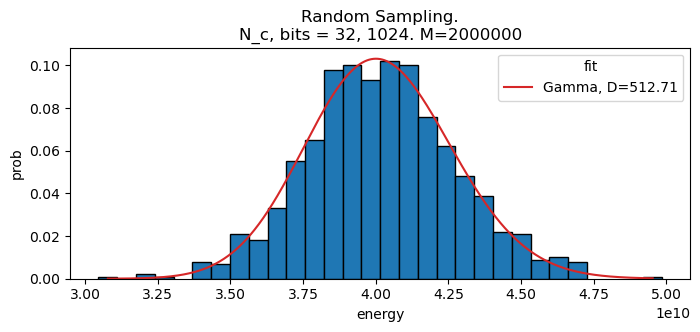

Fit:	dim: 7.0 +- 0.73 	Beta:	1.5e-06


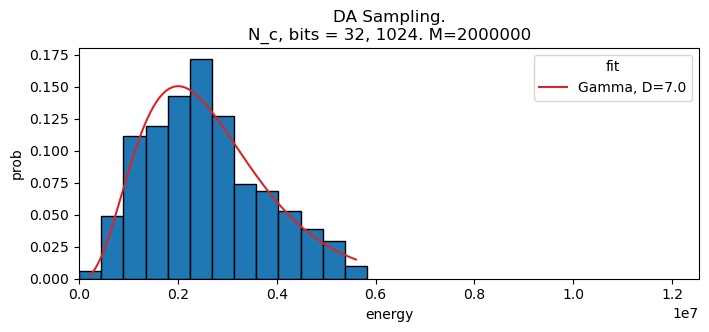

Beta annealing: 2.6e+05


In [73]:
# ### start: optional code to show 2 good examples
# bins = 50
# if N_idx == 3:
#     dimensions = [30]
#     fit_lim = [10**8, 5*10**8] 
# elif N_idx == 2:
#     dimensions = [18]
#     fit_lim = [0.2*10**8, 1.4*10**8] 
# elif N_idx == 1:
#     dimensions = [6]
#     fit_lim = [0, 4*10**7]
# ### end: optional code to show 2 good examples



### Random sampling
counts, x_bins = np.histogram(Es, bins = bins)
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
ax.set_ylabel("prob")
ax.set_xlabel("energy")
plt.title(f"Random Sampling.\nN_c, bits = {Nc}, {Nc**2}. M={M}")
#fit
fit_lim = [np.min(x_pos), np.max(x_pos)]
start, _ = nearest_to(x_pos, fit_lim[0])
end, _ = nearest_to(x_pos, fit_lim[1])
XS = np.linspace(x_pos[start], x_pos[end], 1000)
f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [500, 1e-8])
ax.plot(XS, f(XS, *coef), color = "C3", label = f"Gamma, D={np.round(coef[0], 2)}")
print(f"Fit:\tdim: {np.round(coef[0], 2)} +- {np.round(np.sqrt(coef_var[0, 0]), 2)}\tBeta:\t{np.format_float_scientific(coef[1], 1)}")

ax.legend(fontsize = 10, loc='best', title = "fit")
plt.show()



### DA sampling
# get data to plot
bins = "auto"
ener = np.reshape(data[N_idx, M_idx, 0], newshape = (n_dseeds*runs, 2))
y_ener = ener[:, 0] + ener[:, 1]
optimum = optimum_circle(BITS[N_idx])
y_ener -= optimum
# get histogram data
counts, x_bins = np.histogram(y_ener, bins = bins, range = (0, 2*optimum))
density = counts / counts.sum() # normalize to get a probability
x_pos = (x_bins[1:] + x_bins[:-1])/2
bin_width = x_bins[1]-x_bins[0]
mask = density > 0 # filter out empty bins
density, x_pos = density[mask], x_pos[mask]
# plot
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.bar(x_pos, density, width = bin_width, edgecolor='k', linewidth=1)
ax.set_ylabel("prob")
ax.set_xlabel("energy")
ax.set_xlim(0, 2*optimum)
plt.title(f"DA Sampling.\nN_c, bits = {Nc}, {Nc**2}. M={M}")
#fit
fit_lim = [0, 2] # distance wrt optimum, and scaled wrt optimum
start, _ = nearest_to(x_pos, fit_lim[0]*optimum)
end, _ = nearest_to(x_pos, fit_lim[1]*optimum)
XS = np.linspace(x_pos[start], x_pos[end], 1000)
f = lambda x, D, beta : gamma.pdf(x, (D+1)/2, loc = 0, scale = 1/beta) * bin_width
coef, coef_var = sp.optimize.curve_fit(f, x_pos[start:end+1], density[start:end+1], p0 = [50, 1e-6])
ax.plot(XS, f(XS, *coef), color = "C3", label = f"Gamma, D={np.round(coef[0], 2)}")
print(f"Fit:\tdim: {np.round(coef[0], 2)} +- {np.round(np.sqrt(coef_var[0, 0]), 2)} \tBeta:\t{np.format_float_scientific(coef[1], 1)}")

ax.legend(fontsize = 10, loc='best', title = "fit")
plt.show()


print(f"Beta annealing: {np.format_float_scientific( np.mean(data_temp[N_idx, M_idx, ..., -1]) , 1)}")


## M-method ALGORITHM application

In [6]:
import sys
sys.path.append('../../')
from myalgo import M_method_opt, M_method_feas

### Test M method (create problem, apply technique, simulate Gibbs sampling and plot)

# 1. set problem 
problem_type = "TSP"

N_idx = 4
Nc = N_cities[N_idx]
size = Nc
print(f"TSP problem, size:  Nc = {Nc}, bits = {Nc**2}")
vseed = 42 # only one problem for system size: vseed is always 42
vseed_idx = 0
circle_flag = True

# # 2. set parameters: temperature, min_probabilty, max_energy and vioaltion_peaks
beta_sampling = 1 / np.mean(data_temp[N_idx, :, vseed_idx, :, 1])
min_pfeas = 0.5 # eta
E_f = 3e7
peak_max = 4
E_LB = 0

# 3. apply method to find penalty M
#print("\nApplying method where P_f bound is tighter (almost integration-like)")
M, eta_guaranteed = M_method_opt(size, problem_type, vseed, "seed", beta_sampling, peak_max, min_pfeas, E_f, E_LB, circle_flag)

TSP problem, size:  Nc = 12, bits = 144


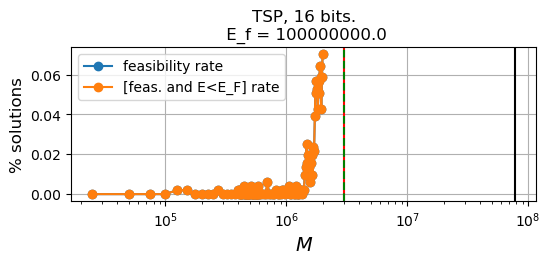

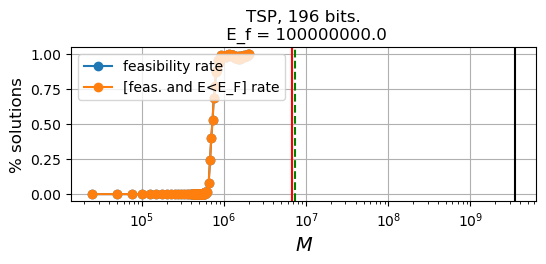

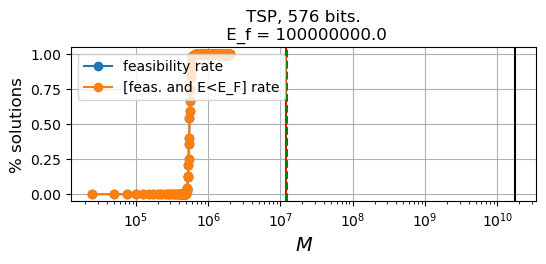

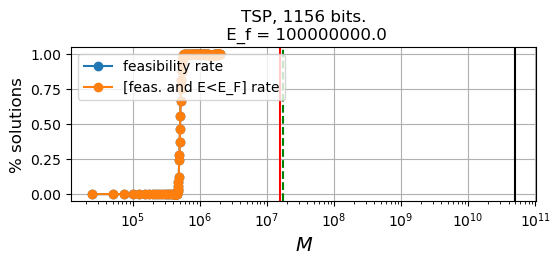

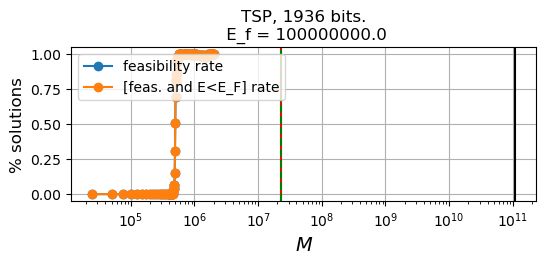

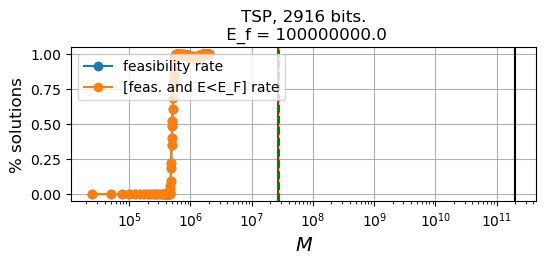

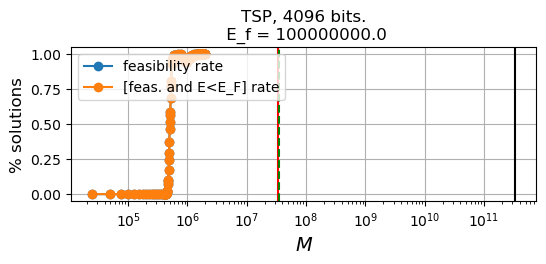

In [7]:
# Test method for all sizes, and compare with empirical cumualtive distribution

problem_type = "TSP"
E_f = 1e8
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4
vseed_idx = 0
vseed = 42
circle_flag = True


for N_idx in np.arange(0, 32, 5):
    Nc = N_cities[N_idx]
    size = Nc
    n_samples = runs * n_dseeds
    feas_prob, opt_prob = np.ndarray((len(Ms))), np.ndarray((len(Ms)))

    # M_trans_approx = 6e5
    # M_idx, _ = nearest_to(Ms, M_trans_approx)
    # beta_sampling_single = 1 / np.mean(data_temp[N_idx, M_idx, vseed_idx, :, 1])

    beta_sampling_mean = 1 / np.mean(data_temp[N_idx, :, vseed_idx, :, 1])
    M_estimated, eta_guaranteed = M_method_opt(size, problem_type, vseed, "seed", beta_sampling_mean, peak_max, min_pfeas, E_f, E_LB, circle_flag)
    M_estimated_feas, eta_guaranteed = M_method_feas(size, problem_type, vseed, "seed", beta_sampling_mean, peak_max, min_pfeas, E_LB, circle_flag)
    #M_estimated_single = M_method_opt(size, problem_type, vseed, "seed", beta_sampling_single, peak_max, min_pfeas, E_f, E_LB)

    # L1 norm estimate of M
    Q_obj, const_obj = get_QUBO_TSP(Nc, 0, vseed, circle_flag = True, penalization=False)
    M_L1 = L1_norm(Q_obj, const_obj)
    M_L1_hot = L1_norm_hot(Q_obj, const_obj, Nc**2, 1/beta_sampling_mean, max_prob_inf = min_pfeas)

    # calculate empirical probs
    for M_idx in range(len(Ms)):
        feas_prob[M_idx] = np.sum( data[N_idx, M_idx, vseed_idx, :, :, 1] == 0) / n_samples
        opt_prob[M_idx] =  np.sum( np.logical_and(data[N_idx, M_idx, vseed_idx, :, :, 1] == 0, data[N_idx, M_idx, vseed_idx, :, :, 0] <= E_f) )  / n_samples
    # plot
    fig = plt.figure(figsize=(6, 2))
    ax = fig.add_subplot(111)
    ax.plot(Ms, feas_prob,"-o", color = "C0", label = 'feasibility rate')
    ax.plot(Ms, opt_prob,"-o", color = "C1", label = '[feas. and E<E_F] rate')
    ax.set_ylabel("% solutions", fontsize=12)
    ax.set_xlabel(r"$M$",fontsize=14)
    ax.legend(fontsize = 10, loc='upper left')
    ax.axvline(M_estimated, color = "r", label = "M_{opt}")
    ax.axvline(M_estimated_feas, color = "g", linestyle = "--", label = "M_{feas}")
    #ax.axvline(M_L1, color = "y")
    ax.axvline(M_L1_hot, color = "k", label = "M_{l1}")

    #ax.axvline(M_estimated_single, color = "k")
    ax.set_title(f"TSP, {N_cities[N_idx]**2} bits.\n E_f = {E_f}")
    ax.set_xscale('log')
    #plt.yscale('log')
    plt.grid()
    plt.show()

        

In [11]:
# ratio M / M_transition   ---   FEASIBILITY strategy


Ncs_idx_ratios = np.arange(0, 32, 2)
ratios_M_feas, ratios_M_l1 = np.ndarray((len(Ncs_idx_ratios), n_vseeds)), np.ndarray((len(Ncs_idx_ratios), n_vseeds))


problem_type = "TSP"
E_f = 1e9
min_pfeas = 0.5 # eta
E_LB = 0
peak_max = 4
circle_flag = True

for N_idx_short, N_idx in enumerate(tqdm.tqdm(Ncs_idx_ratios)):
    Nc = N_cities[N_idx]
    size = Nc
    n_samples = runs * n_dseeds
    opt_prob = np.zeros((len(Ms)))

    
    for inst_idx in range(n_vseeds):
        # compute transition M
        for M_idx in range(len(Ms)):
            #feas_prob[inst_idx, M_idx] = np.sum( data[N_idx, M_idx, inst_idx, :, :, 1] == 0) / n_samples
            opt_prob[M_idx] =  np.sum( np.logical_and(data[N_idx, M_idx, inst_idx, :, :, 1] == 0, data[N_idx, M_idx, inst_idx, :, :, 0] <= E_f) )  / n_samples
        M_idx_trans, opt_prob_trans = nearest_to(opt_prob, .5)
        M_trans = Ms[M_idx_trans]
        
        # compute estimated M
        vseed = 42
        beta_sampling_mean = 1 / np.mean(data_temp[N_idx, :, inst_idx, :, 1])
        M, eta_guaranteed = M_method_feas(size, problem_type, int(vseed), "seed", beta_sampling_mean, peak_max, min_pfeas, E_LB, circle_flag)
        # beta_sampling_single = 1 / np.mean(data_temp[N_idx, M_idx_trans, inst_idx, :, 1])
        # M_estimated_single = M_method_opt(size, problem_type, int(vseed), beta_sampling_single, peak_max, min_pfeas, E_f, E_LB, circle_flag)
        
        # compute M_l1
        Q_obj, const_obj = get_QUBO_TSP(Nc, 0, int(vseed), circle_flag = True, penalization=False)
        M_L1_hot = L1_norm_hot(Q_obj, const_obj, Nc**2, 1/beta_sampling_mean, max_prob_inf = min_pfeas)
        
        ratios_M_feas[N_idx_short, inst_idx] = M / M_trans
        ratios_M_l1[N_idx_short, inst_idx] = M_L1_hot / M_trans

100%|██████████| 16/16 [00:05<00:00,  2.93it/s]


X-Y for our-ratios [  16   64  144  256  400  576  784 1024 1296 1600 1936 2304 2704 3136
 3600 4096] [ 1.5019825   3.64027242  7.63768784 12.6089664  15.60040856 21.99430947
 26.88593222 31.28605998 36.08494064 40.83704307 45.8873678  46.68977367
 53.90608896 57.05413081 61.11673546 65.47153948]
X-Y for l1-ratios [  16   64  144  256  400  576  784 1024 1296 1600 1936 2304 2704 3136
 3600 4096] [3.90750432e+01 6.17822321e+02 2.83989459e+03 8.35783237e+03
 1.70094757e+04 3.20652673e+04 5.23425864e+04 8.44376753e+04
 1.15543589e+05 1.61617587e+05 2.17243624e+05 2.84864893e+05
 3.65847215e+05 4.47762825e+05 5.45240023e+05 6.61679524e+05]


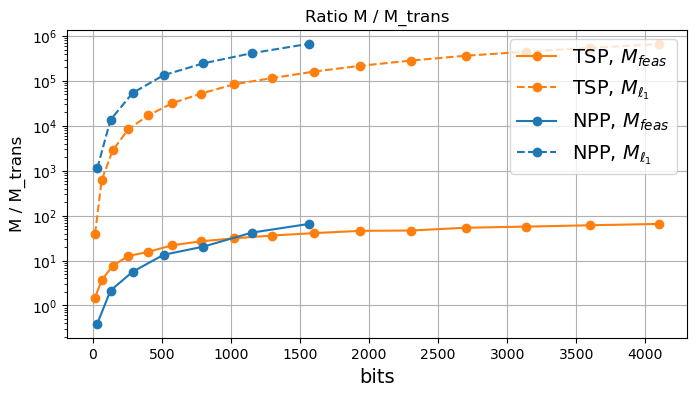

In [13]:
#### plot ratio scaling using feasibility strategy

### NPP data
bits_axes_NPP = [32, 128, 288, 512, 800, 1152, 1568]
ratios_M_NPP_feas = [0.39236133, 2.14692328, 5.63870134, 13.44321408, 20.44231434, 41.96230203, 65.77496125]
ratios_M_NPP_l1 = [1125.13873817, 13674.90026428, 53888.17110512, 134177.28083652, 247078.61272002, 415649.14271532, 674688.2881081]
###

bits_axes = N_cities[Ncs_idx_ratios]**2
## print TSP (this) data if needed in NPP notebook
print("X-Y for our-ratios", bits_axes, ratios_M_feas[:, 0])
print("X-Y for l1-ratios", bits_axes, ratios_M_l1[:, 0])


fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
ax.set_title(f"Ratio M / M_trans")
ax.set_ylabel("M / M_trans", fontsize=12)
ax.set_xlabel("bits",fontsize=14)

ax.plot(bits_axes, ratios_M_feas[:, 0],"-o", color = "C1", label = r"TSP, $M_{feas}$")
ax.plot(bits_axes, ratios_M_l1[:, 0],"--o", color = "C1", label = r"TSP, $M_{\ell_1}$")
ax.plot(bits_axes_NPP, ratios_M_NPP_feas,"-o", color = "C0", label = r"NPP, $M_{feas}$")
ax.plot(bits_axes_NPP, ratios_M_NPP_l1,"--o", color = "C0", label = r"NPP, $M_{\ell_1}$")

ax.set_yscale('log')
ax.legend(fontsize = 14, loc='best')
plt.grid()